In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose #library for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
statsmodels.__version__

data_path = "/content/drive/MyDrive/datasets/dataset_2017_2020.csv"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#read Csv
df = pd.read_csv(data_path)

#create a column for only date
df['transaction_date'] = df.transaction_date.str[:10]
df['t_date'] = pd.to_datetime(df.transaction_date)
df['t_date'] = df.t_date + pd.offsets.MonthBegin(-1)

In [4]:
#groupby by date to see monthly revenue
df_revenue = df.groupby(['t_date']).agg(total_revenue=('price', sum)).reset_index()

In [5]:
#get 3 years to use it in training the ARIMA model
training_data = df_revenue.loc[df_revenue.t_date < '2020-01-01'].set_index('t_date')

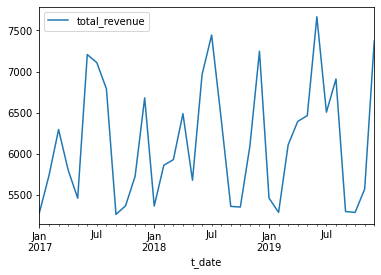

In [6]:
#line plot of total revenue for first 3 years.
training_data.plot()
plt.show()

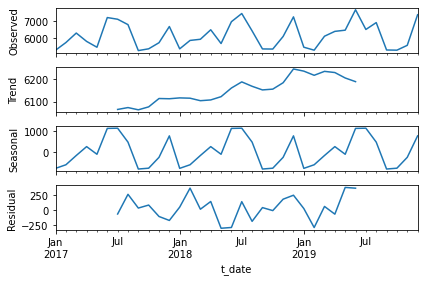

In [7]:
#breaking down the time series to see components and trends.
# - Observed
# - Trend (direction)
# - Seasonal (repeated pattern)
# - Residual (noise)
df_revenue_components = seasonal_decompose(training_data)
df_revenue_components.plot();

In [8]:
#check if the time series is stationary 
#check mean variance of the series

split = round(len(training_data) / 2) # divide data to half
x1 = training_data[0:split] # assign first half to x1
x2 = training_data[split:] # assign second half to x2
mean1= x1.mean() # mean of first half
mean2= x2.mean() # mean of second half
print("Mean 1 & 2= ", mean1[0], mean2[0])
var1=x1.var() #variance of first half
var2=x2.var() #variance of second half
print("Variance 1 & 2= ",var1[0], var2[0])

Mean 1 & 2=  6056.6933333332645 6236.636666666595
Variance 1 & 2=  435629.9484235133 690131.4366235011


In [9]:
#Means are around the same value, but variances seem to be in different ranges.
#Use Augmented Dicket-Fuller(adfuller) test to have a better understanding of time series
#Null hypothesis: The times series is non-stationary, thus it has some time dependent structure
#Alternate hypothesis: The null hypothesis is rejected. The time series is stationary, thus it does not have time dependent structure.

training_adf = training_data.iloc[:,0].values #convert to 1d array as adf only accepts 1d arrays
adf_test = adfuller(training_adf)
print('ADF test = ', adf_test[0])
print('p-value = ', adf_test[1])

ADF test =  -3.9182236153996435
p-value =  0.0019047503928043504


In [10]:
#Given that the ADF value is negative and p-value < 0.05, we can reject the null hyphotesis and tell that our time series is stationary.
#Now we can apply a forecasting method.

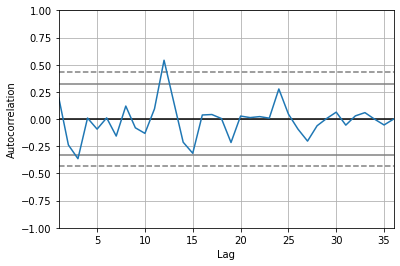

In [11]:
#use autocorrelation plot to define p parameter in ARIMA model
autocorrelation_plot(training_data);

In [12]:
#define test data set
test_data = df_revenue.loc[df_revenue.t_date >= '2020-01-01'].set_index('t_date')
test_data.head()

,total_revenue
t_date,
2020-01-01,5242.21
2020-02-01,6240.52
2020-03-01,5835.69
2020-04-01,6380.56
2020-05-01,6235.96


In [13]:
#transform data into time series.
whole = df_revenue.set_index('t_date').squeeze().copy()
history = whole.take(range(36))
#future containt the test data as a time series
future = test_data.squeeze().copy()
print(type(history))

<class 'pandas.core.series.Series'>


In [14]:
#training the model
for t in range(len(future)):
    model = ARIMA(history, order=(3,0,0), freq='MS')
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    obs = future[t]
    print('prediction', yhat, ', expected', obs)
    history = whole.take(range(36 + t+1))
    print('prediction', yhat, ', expected', obs, ', stderr', output[1], ', conf. int.', output[2])

prediction [6817.039234] , expected 5242.209999999947
prediction [6817.039234] , expected 5242.209999999947 , stderr [646.83725924] , conf. int. [[5549.26150203 8084.81696596]]
prediction [5966.19628177] , expected 6240.519999999956
prediction [5966.19628177] , expected 6240.519999999956 , stderr [683.49718282] , conf. int. [[4626.56641991 7305.82614364]]
prediction [5921.44514398] , expected 5835.689999999932
prediction [5921.44514398] , expected 5835.689999999932 , stderr [675.53514025] , conf. int. [[4597.4205988  7245.46968916]]
prediction [6357.58203974] , expected 6380.559999999933
prediction [6357.58203974] , expected 6380.559999999933 , stderr [666.85539891] , conf. int. [[5050.56947497 7664.59460451]]
prediction [6166.35829768] , expected 6235.959999999937
prediction [6166.35829768] , expected 6235.959999999937 , stderr [658.44818588] , conf. int. [[4875.82356766 7456.8930277 ]]


In [15]:
model = ARIMA(history, order=(3,0,0), freq='MS')
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=18) #forecast the next 18 months in model

In [16]:
sum = output[0][5:-1].sum()

print("Predicted revenue for 2021 : ", sum)

revenue_2019 = 74335.87
expected_2021 = revenue_2019*1.05 #multiply with 1.05 as the expected growth 5 percent

print("Expected revenue for 2021 :", expected_2021)

print("Required growth :", expected_2021-sum)


Predicted revenue for 2021 :  73613.82569578257
Expected revenue for 2021 : 78052.6635
Required growth : 4438.83780421743


In [17]:
output[2] #confidence interval 95%
#for each month the real value 95% chance will fall between these two numbers. 

array([[4919.48832494, 7469.17999821],
       [4769.82803614, 7328.48065805],
       [4793.84273102, 7380.06434191],
       [4766.68012335, 7483.57184579],
       [4807.21710926, 7525.1714179 ],
       [4788.26775586, 7516.43544607],
       [4761.97837954, 7504.70296053],
       [4750.15012501, 7492.89317447],
       [4755.08765713, 7500.19227488],
       [4762.31386734, 7509.09953108],
       [4765.59886378, 7512.39227469],
       [4762.55948637, 7509.80240219],
       [4759.29168124, 7506.72203244],
       [4758.46619082, 7505.90536236],
       [4759.69769648, 7507.21345153],
       [4760.8773843 , 7508.41247263],
       [4761.02614994, 7508.56477089],
       [4760.46635143, 7508.01703523]])